## Подключаем библиотеки

In [ ]:
import matplotlib.pyplot as plt # для построения графиков
import plotly.express as px
import numpy as np # для преобразований

import torch # PyTorch 
import torchvision # загрузка данных
import torchvision.transforms as transforms # преобразование данных
import torch.nn as nn # базовая вещь для нейронных сетей
import torch.nn.functional as F # импорт функций свертки (Relu и др)
import torch.optim as optim # для использования алгоритмов оптимизации, например стохастический градиентный спуск
from tqdm import tqdm

## Считывание данных из гугл-диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os

photos_x10, labels_x10 = [], []
photos_x40, labels_x40 = [], []

directory = os.path.join('/content/drive/MyDrive' ,'H9p36/H9p36')
files = os.listdir(directory)
for file in files:
  filename = file.split('.')
  if filename[1] == 'png':
    picture = filename[0].split('_')
    if len(picture) != 1:
      picture_scale = picture[0].split('x')
      if len(picture_scale) == 1:
        photos_x10.append(picture_scale[0])
        labels_x10.append(picture[1])
      else:
        photos_x40.append(file)
        labels_x40.append(picture[1])

## Приведение всех фотографий к одному размеру

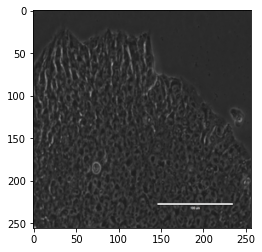

In [ ]:
from PIL import Image
from skimage.color import rgba2rgb

def resize(dataset):
  resize_images = []
  for data in dataset:
    image = Image.open(os.path.join(directory, data))
    image = image.resize((256, 256), Image.ANTIALIAS)
    image = np.array(image)

    if image.shape != (256, 256, 3):
      image = rgba2rgb(image)

    resize_images.append(image)
  return resize_images

resize_photos_x40 = resize(photos_x40)
plt.imshow(resize_photos_x40[-1])

In [ ]:
from skimage.util import img_as_ubyte
from skimage import exposure

equalize_photos_x40 = []

for i in resize_photos_x40:
  img = img_as_ubyte(i)
  img_rescale = exposure.equalize_hist(img)
  equalize_photos_x40.append(img_rescale)

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.



## Приведение изображений к GrayScale

In [ ]:
from skimage.color import rgb2gray

def GrayScale(dataset):
  gray_img = []
  for img in dataset:
    gray = rgb2gray(img)
    gray = np.expand_dims(gray, axis=2)
    gray_img.append(gray)
  return gray_img

gray_photos_x40 = GrayScale(resize_photos_x40)

## Бинаризация

In [ ]:
from skimage.filters import threshold_otsu

otsu_photos_x40 = []

for i in gray_photos_x40:
  thresh = threshold_otsu(i)
  binary = i > thresh
  otsu_photos_x40.append(binary)

## Нормализация изображений

In [ ]:
min_ = []
max_ = []

for photo in resize_photos_x40:
  _max = 0
  _min = 9999
  for i in photo:
    for j in i:
      for k in j:
        if k < _min:
          _min = k
        if k > _max:
          _max = k
  min_.append(_min)
  max_.append(_max)


import copy

def my_normalize1(resize_photos_x40, min_, max_):
  my = copy.deepcopy(resize_photos_x40)
  for photo_id, (photo, _min, _max) in enumerate(zip(resize_photos_x40, min_, max_)):
      my[photo_id] = (photo - _min) / (_max -_min)
  return my

normalize_photos_x40 = my_normalize1(resize_photos_x40, min_, max_)

## Отрисовка картинок с лэйблами

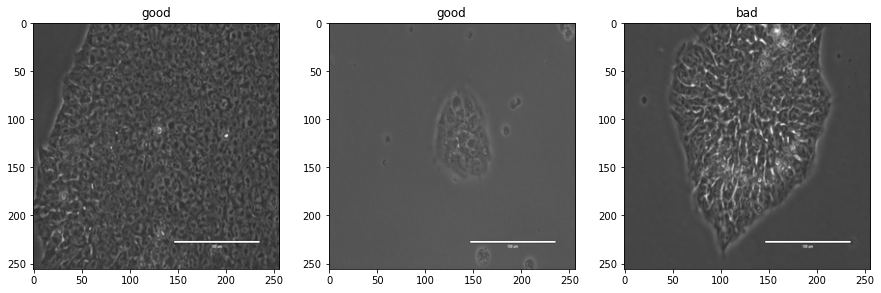

In [ ]:
def beautiful_show_images(dataset, labels, necessary_count):
  fig, axes = plt.subplots(1, necessary_count, figsize = (15, 15))
  plt.gray()

  for i in range(necessary_count):
    tmp = np.random.randint(1, len(dataset))

    axes[i].imshow(dataset[tmp])
    axes[i].set_title(labels[tmp])

beautiful_show_images(resize_photos_x40, labels_x40, 3)

## Разбиение данных на тренировочную и валидационную выборки



In [ ]:
from sklearn.model_selection import train_test_split

def train_val_split(dataset, labels):
  X_train, X_val, y_train, y_val = train_test_split(dataset, labels, test_size=0.2, random_state=1)

  X = {"train":np.array(X_train), "val":np.array(X_val)}
  Labels = {"train":np.array(y_train), "val":np.array(y_val)}
  
  return X, Labels

X, Labels = train_val_split(photos_x40, labels_x40)

## Обёртка данных в DataLoader

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torchvision import datasets
from PIL import Image
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from skimage import exposure


from skimage.io import imread

import albumentations as A

class ClassificationDataSet(Dataset):
    def __init__(self, inputs: list, labels, transform=None, phase='train'):
        transform1 = A.Compose([
          A.RandomCrop(width=256, height=256),
          #A.HorizontalFlip(p=0.5),
          #A.Transpose(p=0.5),
          #A.VerticalFlip(p=0.5),
        ])
        transform2 = A.Compose([
           A.CenterCrop(width=256, height=256)                     
        ])
        self.inputs = inputs
        self.labels = labels
        self.transform = None
        self.inputs_dtype = torch.float
        self.targets_dtype = torch.float
        self.phase = phase
        if self.phase == 'train':
          self.transform =  transform2
        if self.phase == 'val':
          self.transform =  transform1

    def augmentation(self, x):
      return self.transform(image = x)["image"]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index: int):
        input_ID = self.inputs[index]
        x = Image.open(os.path.join(directory, input_ID))   

        if self.transform:
          x = x.resize((512, 512), Image.ANTIALIAS)
          #x = x.resize((256, 256), Image.ANTIALIAS)
          x = np.array(x)

          x  = self.augmentation(x)
        else:
          x = x.resize((256, 256), Image.ANTIALIAS)
          x = np.array(x)


        img = img_as_ubyte(x)
        x = exposure.equalize_hist(img)
        x = rgb2gray(x)
        x = np.expand_dims(x, axis=2)
        x = x.astype(float)

        y = self.labels[index]
        y = torch.from_numpy(np.array(y).astype(float))
        y = y.type(torch.float)

        return torch.from_numpy(x).type(torch.float).permute(2,0,1), y

batch_size = 64
num_workers = 2

for key in Labels:
  Labels[key][Labels[key]=='good'] = 1
  Labels[key][Labels[key]=='bad'] = 0

trainset = ClassificationDataSet(X['train'], Labels['train'], transform=True, phase='train')
valset = ClassificationDataSet(X['val'], Labels['val'], transform=True, phase='val')

dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val': torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }

## Реализация CNN

In [ ]:
def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' Моделирование простой сверточной нейронной сети'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=1, out_channels=thickness)
        self.conv2 = conv3x3(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv12 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)    # 16 256 256
        x = self.conv2(x)          

        x = self.conv3(x)   # 32  128 128
        x = self.conv4(x)   

        x = self.conv5(x)   # 64  64 64
        x = self.conv6(x) 

        x = self.conv7(x)   # 128 32 32
        x = self.conv8(x)   

        x = self.conv9(x) # 128 16 16
        x = self.conv10(x)

        x = self.conv11(x) # 128 8 8
        x = self.conv12(x) # 128 4 4

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)

## VGG12

In [ ]:
def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' Моделирование простой сверточной нейронной сети'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness)
        self.conv2 = conv3x3(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)    # 16 256 256
        x = self.conv2(x)          

        x = self.conv3(x)   # 32  128 128
        x = self.conv4(x)   

        x = self.conv5(x)   # 64  64 64
        x = self.conv6(x) 

        x = self.conv7(x)   # 128 32 32
        x = self.conv8(x)   

        x = self.conv9(x) # 128 16 16
        x = self.conv10(x)

        x = self.conv11(x) # 128 8 8
        
        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net()
net = net.to(device=device)

## VGG12-Pool4

In [ ]:
def conv3x3_maxpool4(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' Моделирование простой сверточной нейронной сети'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 2 * 2, 1)

    def forward(self, x):
        x = self.conv1(x)   # 16 256 256
        x = self.conv2(x)   # 16 64 64 

        x = self.conv3(x)   # 32 64 64
        x = self.conv4(x)   # 32 32 32 

        x = self.conv5(x)   # 64 32 32
        x = self.conv6(x)   # 64 16 16

        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x)   # 128 8 8

        x = self.conv9(x)   # 128 8 8
        x = self.conv10(x)  # 128 4 4

        x = self.conv11(x)  # 128 4 4

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)

## Реализация Модели со Skip Сonnection

In [ ]:
from torch.nn.modules.conv import Conv2d
def conv3x3(in_channels, out_channels, rel=False, batch=False, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
    ]

    if rel:
        layers.append(nn.PReLU(out_channels))

    if batch:
        layers.append(nn.BatchNorm2d(out_channels))

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)

class Net(nn.Module):
    ''' Моделирование простой сверточной нейронной сети'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness, rel=True, batch=True)
        self.conv2 = conv3x3(in_channels=thickness, out_channels=thickness, batch=True, pool=True)
        self.conv_identity1 = Conv2d(in_channels=3, out_channels=thickness, kernel_size=(1, 1), stride=2)
        self.batch1 = nn.BatchNorm2d(thickness)
        self.relu1 = nn.PReLU(thickness)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2, rel=True, batch=True)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, batch=True, pool=True)
        self.conv_identity2 = Conv2d(in_channels=thickness, out_channels=thickness*2, kernel_size=(1, 1), stride=2)
        self.batch2 = nn.BatchNorm2d(thickness*2)
        self.relu2 = nn.PReLU(thickness*2)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4, rel=True, batch=True)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, batch=True, pool=True)
        self.conv_identity3 = Conv2d(in_channels=thickness*2, out_channels=thickness*4, kernel_size=(1, 1), stride=2)
        self.batch3 = nn.BatchNorm2d(thickness*4)
        self.relu3 = nn.PReLU(thickness*4)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8, rel=True, batch=True)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, batch=True, pool=True)
        self.conv_identity4 = Conv2d(in_channels=thickness*4, out_channels=thickness*8, kernel_size=(1, 1), stride=2)
        self.batch4 = nn.BatchNorm2d(thickness*8)
        self.relu4 = nn.PReLU(thickness*8)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, rel=True, batch=True)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, batch=True)
        self.batch5 = nn.BatchNorm2d(thickness*8)
        self.relu5 = nn.PReLU(thickness*8)
      
        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, rel=True, batch=True)
        self.conv12 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, batch=True)
        self.batch6 = nn.BatchNorm2d(thickness*8)
        self.relu6 = nn.PReLU(thickness*8)
	      
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=32)

        self.rel = nn.PReLU()

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        a = x
        x = self.conv1(x)    # 16 256 256
        x = self.conv2(x) 
        y = self.conv_identity1(a)
        x = y + x
        x = self.relu1(x)
        x = self.batch1(x)
        

        a = x         
        x = self.conv3(x)   # 32  128 128
        x = self.conv4(x)
        y = self.conv_identity2(a)
        x = y + x
        x = self.relu2(x)
        x = self.batch2(x)
   

        a = x
        x = self.conv5(x)   # 64  64 64
        x = self.conv6(x) 
        y = self.conv_identity3(a)
        x = y + x
        x = self.relu3(x)
        x = self.batch3(x)

        a = x
        x = self.conv7(x)   # 128 32 32
        x = self.conv8(x) 
        y = self.conv_identity4(a)
        x = y + x
        x = self.relu4(x)
        x = self.batch4(x)

        a = x
        x = self.conv9(x) # 128 16 16
        x = self.conv10(x)
        x = x + a
        x = self.maxpool(x)
        x = self.relu5(x)
        x = self.batch5(x)

        a = x
        x = self.conv11(x) # 128 8 8
        x = self.conv12(x) # 128 4 4
        x = x + a
        x = self.maxpool(x)
        x = self.relu6(x)
        x = self.batch6(x)

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)

## Модель с maxpool4*4 Skip Connection

In [ ]:
from torch.nn.modules.conv import Conv2d

def conv3x3_maxpool4(in_channels, out_channels, rel=False, batch=False, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
    ]

    if rel:
        layers.append(nn.PReLU())

    if batch:
        layers.append(nn.BatchNorm2d(out_channels))

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, rel=False, batch=False, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
    ]

    if rel:
        layers.append(nn.PReLU())

    if batch:
        layers.append(nn.BatchNorm2d(out_channels))

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)

class Net(nn.Module):
    ''' Моделирование простой сверточной нейронной сети'''
	
    def __init__(self, thickness=16):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=1, out_channels=thickness, rel=True, batch=True)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)
        self.conv_identity1 = Conv2d(in_channels=1, out_channels=thickness, kernel_size=(1, 1), stride=4)
        self.batch1 = nn.BatchNorm2d(thickness)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2, rel=True, batch=True)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)
        self.conv_identity2 = Conv2d(in_channels=thickness, out_channels=thickness*2, kernel_size=(1, 1), stride=2)
        self.batch2 = nn.BatchNorm2d(thickness*2)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4, rel=True, batch=True)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)
        self.conv_identity3 = Conv2d(in_channels=thickness*2, out_channels=thickness*4, kernel_size=(1, 1), stride=2)
        self.batch3 = nn.BatchNorm2d(thickness*4)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8, rel=True, batch=True)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)
        self.conv_identity4 = Conv2d(in_channels=thickness*4, out_channels=thickness*8, kernel_size=(1, 1), stride=2)
        self.batch4 = nn.BatchNorm2d(thickness*8)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, rel=True, batch=True)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.batch5 = nn.BatchNorm2d(thickness*8)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, rel=True, batch=True)
        self.conv12 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.batch6 = nn.BatchNorm2d(thickness*8)
	      
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.rel = nn.PReLU()

        self.fc1 = nn.Linear(thickness * 8 * 2 * 2, 1)

    def forward(self, x):
        a = x
        x = self.conv1(x)    # 16 256 256
        x = self.conv2(x) 
        y = self.conv_identity1(a)
        x = y + x
        x = self.rel(x)
        x = self.batch1(x)
        

        a = x         
        x = self.conv3(x)   # 32  64  64
        x = self.conv4(x)
        y = self.conv_identity2(a)
        x = y + x
        x = self.rel(x)
        x = self.batch2(x)
   

        a = x
        x = self.conv5(x)   # 64  32 32
        x = self.conv6(x) 
        y = self.conv_identity3(a)
        x = y + x
        x = self.rel(x)
        x = self.batch3(x)

        a = x
        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x) 
        y = self.conv_identity4(a)
        x = y + x
        x = self.rel(x)
        x = self.batch4(x)

        a = x
        x = self.conv9(x) # 128 8 8
        x = self.conv10(x)
        x = x + a
        x = self.maxpool(x)
        x = self.rel(x)
        x = self.batch5(x)

        a = x
        x = self.conv11(x) # 128 8 8
        x = self.conv12(x) # 128 4 4
        x = x + a
        x = self.maxpool(x)
        x = self.rel(x)
        x = self.batch6(x)


        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)

## Реализация CNN на первом слое maxpool 4*4

In [ ]:
def conv3x3_maxpool4(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' Моделирование простой сверточной нейронной сети'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv12 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 2 * 2, 1)

    def forward(self, x):
        x = self.conv1(x)   # 16 256 256
        x = self.conv2(x)   # 16 64 64 

        x = self.conv3(x)   # 32 64 64
        x = self.conv4(x)   # 32 32 32 

        x = self.conv5(x)   # 64 32 32
        x = self.conv6(x)   # 64 16 16

        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x)   # 128 8 8

        x = self.conv9(x)   # 128 8 8
        x = self.conv10(x)  # 128 4 4

        x = self.conv11(x)  # 128 4 4
        x = self.conv12(x)  # 128 2 2

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)

## Реализация CNN с maxpool и без последнего conv слоя

In [ ]:
def conv3x3_maxpool4(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' Моделирование простой сверточной нейронной сети'''
	
    def __init__(self, thickness=16):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)   # 16 256 256
        x = self.conv2(x)   # 16 64 64 

        x = self.conv3(x)   # 32 64 64
        x = self.conv4(x)   # 32 32 32 

        x = self.conv5(x)   # 64 32 32
        x = self.conv6(x)   # 64 16 16

        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x)   # 128 8 8

        x = self.conv9(x)   # 128 8 8
        x = self.conv10(x)  # 128 4 4

        x = self.conv11(x)  # 128 4 4

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(8)
net = net.to(device=device)
print(net)

## Реализация CNN без двух последних conv

In [ ]:
def conv3x3_maxpool4(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' Моделирование простой сверточной нейронной сети'''
	
    def __init__(self, thickness=16):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=1, out_channels=thickness)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)   # 16 256 256
        x = self.conv2(x)   # 16 64 64 

        x = self.conv3(x)   # 32 64 64
        x = self.conv4(x)   # 32 32 32 

        x = self.conv5(x)   # 64 32 32
        x = self.conv6(x)   # 64 16 16

        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x)   # 128 8 8

        x = self.conv9(x)   # 128 8 8
        x = self.conv10(x)  # 128 4 4

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(8)
net = net.to(device=device)
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool

## Определение функции потерь и оптимизатора

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
'''
optim.SGD → Реализует стохастический градиентный спуск
net.parameters() → получает обучаемые параметры CNN
lr → скорость обучения градиентного спуска (насколько большой шаг вы делаете)
momentum → импульс помогает ускорить векторы градиента в нужных направлениях, что приводит к более быстрой сходимости
'''
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())
scheduler = ReduceLROnPlateau(optimizer, 'min')

## Построение графиков обучения

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def create_plots1(epochs_train, epochs_valid, epoch_valid_metrics):
  t = np.linspace(1, len(epochs_train), len(epochs_train))
  x_rev = t[::-1]
  
  valid_scores_mean = np.mean(epochs_valid)
  valid_scores_std = np.std(epochs_valid)
  train_scores_mean = np.mean(epochs_train)
  train_scores_std = np.std(epochs_train)

  ci_valid = []
  ci_train = []

  for i in range(len(epochs_valid)):
    ci_valid.append(epochs_valid[i] * valid_scores_std / valid_scores_mean)
    ci_train.append(epochs_valid[i] * train_scores_std / train_scores_mean)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=t, y=epochs_valid,
                      mode='lines+markers',
                      name='Validation'))
  
  fig.add_trace(go.Scatter(x=t, y=epochs_train,
                      mode='lines+markers',
                      name='Training'))

  y_u_valid = []
  y_l_valid = []

  for i in range(len(epochs_valid)):
    y_u_valid.append(epochs_valid[i] + ci_valid[i])
    y_l_valid.append(epochs_valid[i] - ci_valid[i])
  y_l_valid = y_l_valid[::-1]

  fig.add_trace(go.Scatter(
    x=np.concatenate([t, x_rev]),
    y=np.concatenate([y_u_valid, y_l_valid]),
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)', 
  ))

  y_u_train = []
  y_l_train = []

  for i in range(len(epochs_train)):
    y_u_train.append(epochs_train[i] + ci_train[i])
    y_l_train.append(epochs_train[i] - ci_train[i])
  y_l_train = y_l_train[::-1]

  fig.add_trace(go.Scatter(
    x=np.concatenate([t, x_rev]),
    y=np.concatenate([y_u_train, y_l_train]),
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line_color='rgba(255,255,255,0)', 
  ))

  fig.update_layout(legend_title_text = "Phase")
  fig.update_xaxes(title_text="Epochs")
  fig.update_yaxes(title_text="Value")
  fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def create_plots(epochs_train,epochs_valid, epoch_valid_metrics):
  t = np.linspace(1, len(epochs_train), len(epochs_train))
  x_rev = t[::-1]
  
  valid_scores_mean = np.mean(epochs_valid)
  valid_scores_std = np.std(epochs_valid)
  train_scores_mean = np.mean(epochs_train)
  train_scores_std = np.std(epochs_train)

  ci_valid = 0.05 * valid_scores_std / valid_scores_mean
  ci_train = 0.05 * train_scores_std / train_scores_mean

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=t, y=epochs_valid,
                      mode='lines+markers',
                      name='Validation'))
  
  fig.update_traces(mode='lines')
  
  fig.add_trace(go.Scatter(x=t, y=epochs_train,
                      mode='lines+markers',
                      name='Training'))

  y_u = epochs_valid + ci_valid
  y_l = epochs_valid - ci_valid
  y_l = y_l[::-1]

  fig.add_trace(go.Scatter(
    x=np.concatenate([t, x_rev]),
    y=np.concatenate([y_u, y_l]),
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)', 
  ))

  fig.update_layout(legend_title_text = "Phase")
  fig.update_xaxes(title_text="Epochs")
  fig.update_yaxes(type="log", title_text="Log(Value)")

  fig.show()


  fig = go.Figure()
  fig.add_trace(go.Scatter(x=t, y=epochs_valid,
                      mode='lines+markers',
                      name='Validation'))
  
  fig.add_trace(go.Scatter(x=t, y=epochs_train,
                      mode='lines+markers',
                      name='Training'))
  
  fig.update_layout(legend_title_text = "Phase")
  fig.update_xaxes(title_text="Epochs")
  fig.update_yaxes(title_text="Value")
  fig.show()


  fig = go.Figure()
  fig.add_trace(go.Scatter(x=t, y=epoch_valid_metrics['Accuracy'],
                      mode='lines+markers',
                      name='Accuracy'))

  fig.add_trace(go.Scatter(x=t, y=epoch_valid_metrics['Precision'],
                      mode='lines+markers',
                      name='Precision'))
  
  fig.add_trace(go.Scatter(x=t, y=epoch_valid_metrics['Recall'],
                      mode='lines+markers',
                      name='Recall'))
                      
  fig.add_trace(go.Scatter(x=t, y=epoch_valid_metrics['F1'],
                    mode='lines+markers',
                    name='F1'))
  
  fig.update_layout(legend_title_text = "Metrics")
  fig.update_xaxes(title_text="Epochs")
  fig.update_yaxes(title_text="Value")

  fig.show()


## Сохранение лучших параметров модели в текстовый файл

In [ ]:
model_directory = os.path.join('/content/drive/MyDrive' ,'Experiments/2')

def write_metrics_in_file(epochs_train, epochs_valid, epoch_valid_metrics):
  print(epochs_train)
  print()
  print(epochs_valid)
  print()
  print(epoch_valid_metrics)
  
  with open(os.path.join(model_directory, "epochs_valid_metrics.txt"), 'a') as file:
    file.write(f"{epoch_valid_metrics['Accuracy'][-1]} {epoch_valid_metrics['Precision'][-1]} {epoch_valid_metrics['Recall'][-1]} {epoch_valid_metrics['F1'][-1]} \n")
  
  with open(os.path.join(model_directory, "epochs_valid.txt"), 'a') as f:
    f.write(f"{epochs_valid[-1]} \n")
  with open(os.path.join(model_directory, "epochs_train.txt"), 'a') as f:
    f.write(f"{epochs_train[-1]} \n")
  

## Обучение нейронной сети

In [ ]:
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from torch.nn.functional import normalize

epochs = 100
border = 0.7
best_F_score = 0
phases = ['train', 'val']

epochs_valid = []
epoch_valid_metrics = defaultdict(list)
epochs_train = []
for epoch in range(epochs):  # многократное прохождение по набору данных
    loss_train = []
    loss_valid = []
    for phase in phases:
      running_loss = 0.0
      prediction = []
      label = [] 

      for i, data in tqdm(enumerate(dataloaders[phase]), total = len(dataloaders[phase])):
          # получить входные данные; данные - это список [inputs, labels]
          inputs, labels = data
          print(inputs.shape)
          # raise Exception
          img = inputs[0].permute(1,2,0).numpy()
          #plt.imshow(img.astype(int))
          #plt.show()
          #inputs = normalize(inputs, p=2.0, dim = 0)
          #img = 255 * inputs[0].permute(1,2,0).numpy()
          #plt.imshow(img.astype(int))
          #plt.show()
          #raise Exception

          inputs, labels = inputs.to(device), labels.to(device)

          # обнулить параметры градиента
          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == "train"):
            outputs = net(inputs.float())
            loss = criterion(outputs.flatten(), labels)
            if phase == 'train':
              loss.backward()
              optimizer.step()
              loss_train.append(loss.item())
            if phase == 'val':
              loss_valid.append(loss.item())
              res = outputs.detach().cpu().numpy() 
              res = res > border
              res  = res.astype(int)
              res = res.squeeze()
              prediction.extend(res)
              labels = labels.detach().cpu().numpy()
              label.extend(labels)
            if i % 5 == 0:
              tqdm.write(f"Epochs[{epoch+1}/{epochs}], phase:{phase}")
            running_loss = 0.0

      if phase == 'train':
        epochs_train.append(np.mean(loss_train))


      if phase == "val":
          epochs_valid.append(np.mean(loss_valid))


          conf_mtrx = confusion_matrix(label, prediction)
          accuracy = (conf_mtrx[0, 0] + conf_mtrx[1, 1]) / (conf_mtrx[0, 0] + conf_mtrx[1, 1] + conf_mtrx[0, 1] + conf_mtrx[1, 0])
          precision = (conf_mtrx[0, 0]) / (conf_mtrx[0, 0] + conf_mtrx[0, 1])
          recall = (conf_mtrx[0, 0]) / (conf_mtrx[0, 0] + conf_mtrx[1, 0])
          F_1 = 2 * (precision * recall) / (precision + recall)
          epoch_valid_metrics["Accuracy"].append(accuracy)
          epoch_valid_metrics["Precision"].append(precision)
          epoch_valid_metrics["Recall"].append(recall)
          epoch_valid_metrics["F1"].append(F_1)
          tqdm.write(f"Epochs[{epoch+1}/{epochs}], Accuracy {accuracy},  Precision {precision}, Recall {recall}, F1 {F_1} ")

          loss_valid = []
          if best_F_score < epoch_valid_metrics["F1"][-1]:
            best_conf = np.copy(confusion_matrix)
            best_epoch = epoch + 1
            best_F_score = epoch_valid_metrics["F1"][-1]
            torch.save(net.state_dict(), os.path.join(model_directory, f"{'Simple_model'}_best_model_{round(best_F_score, 2)}.pt"))

    torch.save(net.state_dict(), os.path.join(model_directory, f"{'Simple_model'}_last_model.pt"))
    write_metrics_in_file(epochs_train, epochs_valid, epoch_valid_metrics)

#create_plots1(epochs_train, epochs_valid, epoch_valid_metrics)
#plots(epochs_train, epochs_valid, epoch_valid_metrics)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


torch.Size([64, 1, 256, 256])


 50%|█████     | 2/4 [00:13<00:11,  5.68s/it]

Epochs[1/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:16<00:04,  4.20s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[1/100], phase:val
Epochs[1/100], Accuracy 0.6851851851851852,  Precision 0.8461538461538461, Recall 0.6285714285714286, F1 0.721311475409836 


[0.7535559237003326]

[0.6164856553077698]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852], 'Precision': [0.8461538461538461], 'Recall': [0.6285714285714286], 'F1': [0.721311475409836]})


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.30s/it]

torch.Size([64, 1, 256, 256])
Epochs[2/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[2/100], phase:val
Epochs[2/100], Accuracy 0.6111111111111112,  Precision 0.8461538461538461, Recall 0.5641025641025641, F1 0.676923076923077 
[0.7535559237003326, 0.4521922245621681]

[0.6164856553077698, 0.6365352272987366]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112], 'Precision': [0.8461538461538461, 0.8461538461538461], 'Recall': [0.6285714285714286, 0.5641025641025641], 'F1': [0.721311475409836, 0.676923076923077]})



  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.26s/it]

torch.Size([64, 1, 256, 256])
Epochs[3/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[3/100], phase:val
Epochs[3/100], Accuracy 0.6296296296296297,  Precision 0.8461538461538461, Recall 0.5789473684210527, F1 0.6875 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461], 'Recall': [0.6285714285714286, 0.5641025641025641, 0.5789473684210527], 'F1': [0.721311475409836, 0.676923076923077, 0.6875]})



  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.25s/it]

torch.Size([64, 1, 256, 256])
Epochs[4/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[4/100], phase:val
Epochs[4/100], Accuracy 0.6481481481481481,  Precision 0.8846153846153846, Recall 0.5897435897435898, F1 0.7076923076923076 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8846153846153846], 'Recall': [0.6285714285714286, 0.5641025641025641, 0.5789473684210527, 0.5897435897435898], 'F1': [0.721311475409836, 0.676923076923077, 0.6875, 0.7076923076923076]})



  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.22s/it]

torch.Size([64, 1, 256, 256])
Epochs[5/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[5/100], phase:val
Epochs[5/100], Accuracy 0.7222222222222222,  Precision 0.9230769230769231, Recall 0.6486486486486487, F1 0.7619047619047619 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8846153846153846, 0.9230769230769231], 'Recall': [0.6285714285714286, 0.5641025641025641, 0.5789473684210527, 0.5897435897435898, 0.6486486486486487], 'F1': [0.721311475409836, 0.676923076923077, 0.6875, 0.7076923076923076, 0.7619047619047619]})



  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:13,  4.63s/it]

torch.Size([64, 1, 256, 256])
Epochs[6/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.50s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[6/100], phase:val
Epochs[6/100], Accuracy 0.7037037037037037,  Precision 0.8846153846153846, Recall 0.6388888888888888, F1 0.7419354838709676 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8846153846153846, 0.9230769230769231, 0.8846153846153846], 'Recall': [0.6285714285714286, 0.5641025641025641, 0.5789473684210527, 0.5897435897435898, 0.6486486486486487, 0.6388888888888888], 'F1': [0.721311475409836, 0.676923076923077, 0.6875, 0.7076923076923076, 0.7619047619047619, 0.7419354838709676]})



  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.24s/it]

torch.Size([64, 1, 256, 256])
Epochs[7/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

torch.Size([54, 1, 256, 256])
Epochs[7/100], phase:val
Epochs[7/100], Accuracy 0.6296296296296297,  Precision 0.8076923076923077, Recall 0.5833333333333334, F1 0.6774193548387097 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8846153846153846, 0.9230769230769231, 0.8846153846153846, 0.8076923076923077], 'Recall': [0.6285714285714286, 0.5641025641025641, 0.5789473684210527, 0.5897435897435898, 0.6486486486486487, 0.6388888888888888, 0.5833333333333334], 'F1': [0.721311475409836, 0.67692307692307


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.27s/it]

torch.Size([64, 1, 256, 256])
Epochs[8/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

torch.Size([54, 1, 256, 256])
Epochs[8/100], phase:val
Epochs[8/100], Accuracy 0.7037037037037037,  Precision 0.8461538461538461, Recall 0.6470588235294118, F1 0.7333333333333334 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.7037037037037037], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8846153846153846, 0.9230769230769231, 0.8846153846153846, 0.8076923076923077, 0.8461538461538461], 'Recall': [0.6285714285714286, 0.5641025641025641, 0.5789473684210527, 0.5897435897435898, 0.6486486486486487, 0.


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.23s/it]

torch.Size([64, 1, 256, 256])
Epochs[9/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:08<00:02,  2.72s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[9/100], phase:val
Epochs[9/100], Accuracy 0.6851851851851852,  Precision 0.8461538461538461, Recall 0.6285714285714286, F1 0.721311475409836 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.7037037037037037, 0.6851851851851852], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8846153846153846, 0.9230769230769231, 0.8846153846153846, 0.8076923076923077, 0.8461538461538461, 0.8461538461538461], 'Recall': [0.6285714285714286, 0.


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.26s/it]

torch.Size([64, 1, 256, 256])
Epochs[10/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[10/100], phase:val
Epochs[10/100], Accuracy 0.7037037037037037,  Precision 0.8846153846153846, Recall 0.6388888888888888, F1 0.7419354838709676 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.7037037037037037, 0.6851851851851852, 0.7037037037037037], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8846153846153846, 0.9230769230769231, 0.8846153846153846, 0.8076923076923077, 0.8461538


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.28s/it]

torch.Size([64, 1, 256, 256])
Epochs[11/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[11/100], phase:val
Epochs[11/100], Accuracy 0.7222222222222222,  Precision 0.9230769230769231, Recall 0.6486486486486487, F1 0.7619047619047619 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.7037037037037037, 0.6851851851851852, 0.7037037037037037, 0.7222222222222222], 'Precision': [0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8846153846153846, 0.9230


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.28s/it]

torch.Size([64, 1, 256, 256])
Epochs[12/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[12/100], phase:val
Epochs[12/100], Accuracy 0.7222222222222222,  Precision 0.8846153846153846, Recall 0.6571428571428571, F1 0.7540983606557377 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.7037037037037037, 0.6851851851851852, 0.7037037037037037, 0.7222222222222222, 0.7222222222222222], 'Precision': [0.8461538461538461, 0.84


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:13,  4.38s/it]

torch.Size([64, 1, 256, 256])
Epochs[13/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[13/100], phase:val
Epochs[13/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.7037037037037037, 0.6851851851851852, 0.7037037037037037, 0.7222222222222222, 0.722222222222222


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.18s/it]

torch.Size([64, 1, 256, 256])
Epochs[14/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[14/100], phase:val
Epochs[14/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.7037037037037037, 0.6851851851851852, 0.703703703703


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.31s/it]

torch.Size([64, 1, 256, 256])
Epochs[15/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[15/100], phase:val
Epochs[15/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.7037037037037037, 0.6296296296296297, 0.703703703


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.22s/it]

torch.Size([64, 1, 256, 256])
Epochs[16/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[16/100], phase:val
Epochs[16/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931, 0.65839684009552]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.6481481481481481, 0.7222222222222222, 0.703703703


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[17/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[17/100], phase:val
Epochs[17/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931, 0.65839684009552, 0.6579468250274658]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111111111111112, 0.6296296296296297, 0.648148


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.24s/it]

torch.Size([64, 1, 256, 256])
Epochs[18/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[18/100], phase:val
Epochs[18/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931, 0.65839684009552, 0.6579468250274658, 0.6586955785751343]

defaultdict(<class 'list'>, {'Accuracy': [0.6851851851851852, 0.6111


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[19/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[19/100], phase:val
Epochs[19/100], Accuracy 0.7592592592592593,  Precision 0.9230769230769231, Recall 0.6857142857142857, F1 0.7868852459016394 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931, 0.65839684009552, 0.6579468250274658, 0.6586955785751343, 0.6610610485076904]

defaultdict(<class 'list'


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.18s/it]

torch.Size([64, 1, 256, 256])
Epochs[20/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[20/100], phase:val
Epochs[20/100], Accuracy 0.7592592592592593,  Precision 0.9230769230769231, Recall 0.6857142857142857, F1 0.7868852459016394 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931, 0.65839684009552, 0.6579468250274658, 0.6586955785751343, 0.6610610485076904, 0.6


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:13,  4.34s/it]

torch.Size([64, 1, 256, 256])
Epochs[21/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:08<00:02,  2.69s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

torch.Size([54, 1, 256, 256])
Epochs[21/100], phase:val
Epochs[21/100], Accuracy 0.7592592592592593,  Precision 0.9230769230769231, Recall 0.6857142857142857, F1 0.7868852459016394 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931, 0.65839684009552, 0.6579468250274658, 0.6586955785751343, 0


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.14s/it]

torch.Size([64, 1, 256, 256])
Epochs[22/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.34s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

torch.Size([54, 1, 256, 256])
Epochs[22/100], phase:val
Epochs[22/100], Accuracy 0.7592592592592593,  Precision 0.9230769230769231, Recall 0.6857142857142857, F1 0.7868852459016394 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931, 0.65839684009552, 0.6579468250274658


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.24s/it]

torch.Size([64, 1, 256, 256])
Epochs[23/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[23/100], phase:val
Epochs[23/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.6590143442153931, 0.65839684009


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.28s/it]

torch.Size([64, 1, 256, 256])
Epochs[24/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.86s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[24/100], phase:val
Epochs[24/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.6577020883560181, 0.659014344


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.17s/it]

torch.Size([64, 1, 256, 256])
Epochs[25/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

torch.Size([54, 1, 256, 256])
Epochs[25/100], phase:val
Epochs[25/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503894925117493, 0.657702


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
  0%|          | 0/4 [00:04<?, ?it/s]

torch.Size([64, 1, 256, 256])
Epochs[26/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.84s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[26/100], phase:val
Epochs[26/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6468639969825745, 0.6503


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[27/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[27/100], phase:val
Epochs[27/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0.6461341381072998, 0.6


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.26s/it]

torch.Size([64, 1, 256, 256])
Epochs[28/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[28/100], phase:val
Epochs[28/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373, 0.6483507752418518, 0


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.27s/it]

torch.Size([64, 1, 256, 256])
Epochs[29/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[29/100], phase:val
Epochs[29/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606567, 0.6453864574432373


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.32s/it]

torch.Size([64, 1, 256, 256])
Epochs[30/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[30/100], phase:val
Epochs[30/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967056274, 0.6474591493606


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.20s/it]

torch.Size([64, 1, 256, 256])
Epochs[31/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[31/100], phase:val
Epochs[31/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518594741821, 0.6422868967


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[32/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[32/100], phase:val
Epochs[32/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987957119941711, 0.6164518


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.27s/it]

torch.Size([64, 1, 256, 256])
Epochs[33/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[33/100], phase:val
Epochs[33/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6331254243850708, 0.5987


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[34/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[34/100], phase:val
Epochs[34/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182]

[0.6164856553077698, 0.6365352272987366, 0.6421661376953125, 0.6


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.26s/it]

torch.Size([64, 1, 256, 256])
Epochs[35/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.84s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[35/100], phase:val
Epochs[35/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987]

[0.6164856553077698, 0.6365352272987366, 


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.25s/it]

torch.Size([64, 1, 256, 256])
Epochs[36/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[36/100], phase:val
Epochs[36/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392]

[0.616485655307769


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.25s/it]

torch.Size([64, 1, 256, 256])
Epochs[37/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[37/100], phase:val
Epochs[37/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[38/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[38/100], phase:val
Epochs[38/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.25s/it]

torch.Size([64, 1, 256, 256])
Epochs[39/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

torch.Size([54, 1, 256, 256])
Epochs[39/100], phase:val
Epochs[39/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[40/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[40/100], phase:val
Epochs[40/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.20s/it]

torch.Size([64, 1, 256, 256])
Epochs[41/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[41/100], phase:val
Epochs[41/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.16s/it]

torch.Size([64, 1, 256, 256])
Epochs[42/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.42s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[42/100], phase:val
Epochs[42/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.15s/it]

torch.Size([64, 1, 256, 256])
Epochs[43/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.82s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[43/100], phase:val
Epochs[43/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.16s/it]

torch.Size([64, 1, 256, 256])
Epochs[44/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[44/100], phase:val
Epochs[44/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.31s/it]

torch.Size([64, 1, 256, 256])
Epochs[45/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[45/100], phase:val
Epochs[45/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.20s/it]

torch.Size([64, 1, 256, 256])
Epochs[46/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[46/100], phase:val
Epochs[46/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.26s/it]

torch.Size([64, 1, 256, 256])
Epochs[47/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[47/100], phase:val
Epochs[47/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.25s/it]

torch.Size([64, 1, 256, 256])
Epochs[48/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.84s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[48/100], phase:val
Epochs[48/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.22s/it]

torch.Size([64, 1, 256, 256])
Epochs[49/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[49/100], phase:val
Epochs[49/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[50/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

torch.Size([54, 1, 256, 256])
Epochs[50/100], phase:val
Epochs[50/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.28s/it]

torch.Size([64, 1, 256, 256])
Epochs[51/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

torch.Size([54, 1, 256, 256])
Epochs[51/100], phase:val
Epochs[51/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[52/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[52/100], phase:val
Epochs[52/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.16s/it]

torch.Size([64, 1, 256, 256])
Epochs[53/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.80s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[53/100], phase:val
Epochs[53/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.16s/it]

torch.Size([64, 1, 256, 256])
Epochs[54/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[54/100], phase:val
Epochs[54/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[55/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[55/100], phase:val
Epochs[55/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.16s/it]

torch.Size([64, 1, 256, 256])
Epochs[56/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

torch.Size([54, 1, 256, 256])
Epochs[56/100], phase:val
Epochs[56/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[57/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[57/100], phase:val
Epochs[57/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[58/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.45s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:03<00:00,  3.02s/it]

torch.Size([54, 1, 256, 256])
Epochs[58/100], phase:val
Epochs[58/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[59/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[59/100], phase:val
Epochs[59/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.22s/it]

torch.Size([64, 1, 256, 256])
Epochs[60/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[60/100], phase:val
Epochs[60/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.23s/it]

torch.Size([64, 1, 256, 256])
Epochs[61/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[61/100], phase:val
Epochs[61/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.16s/it]

torch.Size([64, 1, 256, 256])
Epochs[62/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.81s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[62/100], phase:val
Epochs[62/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.20s/it]

torch.Size([64, 1, 256, 256])
Epochs[63/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.42s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[63/100], phase:val
Epochs[63/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.33s/it]

torch.Size([64, 1, 256, 256])
Epochs[64/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[64/100], phase:val
Epochs[64/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[65/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

torch.Size([54, 1, 256, 256])
Epochs[65/100], phase:val
Epochs[65/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.16s/it]

torch.Size([64, 1, 256, 256])
Epochs[66/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

torch.Size([54, 1, 256, 256])
Epochs[66/100], phase:val
Epochs[66/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.20s/it]

torch.Size([64, 1, 256, 256])
Epochs[67/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[67/100], phase:val
Epochs[67/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[68/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[68/100], phase:val
Epochs[68/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.18s/it]

torch.Size([64, 1, 256, 256])
Epochs[69/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[69/100], phase:val
Epochs[69/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.14s/it]

torch.Size([64, 1, 256, 256])
Epochs[70/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[70/100], phase:val
Epochs[70/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
  0%|          | 0/4 [00:04<?, ?it/s]

torch.Size([64, 1, 256, 256])
Epochs[71/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.85s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.34s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[71/100], phase:val
Epochs[71/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.27s/it]

torch.Size([64, 1, 256, 256])
Epochs[72/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.84s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

torch.Size([54, 1, 256, 256])
Epochs[72/100], phase:val
Epochs[72/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[73/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[73/100], phase:val
Epochs[73/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[74/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.82s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[74/100], phase:val
Epochs[74/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.22s/it]

torch.Size([64, 1, 256, 256])
Epochs[75/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[75/100], phase:val
Epochs[75/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[76/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.81s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[76/100], phase:val
Epochs[76/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.24s/it]

torch.Size([64, 1, 256, 256])
Epochs[77/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[77/100], phase:val
Epochs[77/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.15s/it]

torch.Size([64, 1, 256, 256])
Epochs[78/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[78/100], phase:val
Epochs[78/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[79/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[79/100], phase:val
Epochs[79/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[80/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.40s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[80/100], phase:val
Epochs[80/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.26s/it]

torch.Size([64, 1, 256, 256])
Epochs[81/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.42s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[81/100], phase:val
Epochs[81/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.26s/it]

torch.Size([64, 1, 256, 256])
Epochs[82/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[82/100], phase:val
Epochs[82/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.13s/it]

torch.Size([64, 1, 256, 256])
Epochs[83/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.80s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

torch.Size([54, 1, 256, 256])
Epochs[83/100], phase:val
Epochs[83/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.16s/it]

torch.Size([64, 1, 256, 256])
Epochs[84/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[84/100], phase:val
Epochs[84/100], Accuracy 0.7407407407407407,  Precision 0.8846153846153846, Recall 0.6764705882352942, F1 0.7666666666666666 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.22s/it]

torch.Size([64, 1, 256, 256])
Epochs[85/100], phase:train


 50%|█████     | 2/4 [00:04<00:03,  1.83s/it]

torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[85/100], phase:val
Epochs[85/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.32s/it]

torch.Size([64, 1, 256, 256])
Epochs[86/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.41s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[86/100], phase:val
Epochs[86/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[87/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[87/100], phase:val
Epochs[87/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.18s/it]

torch.Size([64, 1, 256, 256])
Epochs[88/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[88/100], phase:val
Epochs[88/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.13s/it]

torch.Size([64, 1, 256, 256])
Epochs[89/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[89/100], phase:val
Epochs[89/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[90/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

torch.Size([54, 1, 256, 256])
Epochs[90/100], phase:val
Epochs[90/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[91/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[91/100], phase:val
Epochs[91/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[92/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[92/100], phase:val
Epochs[92/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.15s/it]

torch.Size([64, 1, 256, 256])
Epochs[93/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

torch.Size([54, 1, 256, 256])
Epochs[93/100], phase:val
Epochs[93/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.18s/it]

torch.Size([64, 1, 256, 256])
Epochs[94/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.39s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[94/100], phase:val
Epochs[94/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[95/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

torch.Size([54, 1, 256, 256])
Epochs[95/100], phase:val
Epochs[95/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.18s/it]

torch.Size([64, 1, 256, 256])
Epochs[96/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:08<00:02,  2.90s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

torch.Size([54, 1, 256, 256])
Epochs[96/100], phase:val
Epochs[96/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

torch.Size([64, 1, 256, 256])
Epochs[97/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

torch.Size([54, 1, 256, 256])
Epochs[97/100], phase:val
Epochs[97/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.17s/it]

torch.Size([64, 1, 256, 256])
Epochs[98/100], phase:train


 75%|███████▌  | 3/4 [00:07<00:02,  2.38s/it]

torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

torch.Size([54, 1, 256, 256])
Epochs[98/100], phase:val
Epochs[98/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

torch.Size([64, 1, 256, 256])
Epochs[99/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

torch.Size([54, 1, 256, 256])
Epochs[99/100], phase:val
Epochs[99/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.00063018519722390


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
 25%|██▌       | 1/4 [00:04<00:12,  4.24s/it]

torch.Size([64, 1, 256, 256])
Epochs[100/100], phase:train
torch.Size([64, 1, 256, 256])


 75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

torch.Size([64, 1, 256, 256])
torch.Size([23, 1, 256, 256])


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([54, 1, 256, 256])
Epochs[100/100], phase:val
Epochs[100/100], Accuracy 0.7222222222222222,  Precision 0.8461538461538461, Recall 0.6666666666666666, F1 0.7457627118644068 
[0.7535559237003326, 0.4521922245621681, 0.2435118518769741, 0.1645483747124672, 0.08492551185190678, 0.05701608955860138, 0.033325772266834974, 0.02101716585457325, 0.01491335011087358, 0.009449462173506618, 0.0062805196503177285, 0.005108476849272847, 0.004291952238418162, 0.0030244668596424162, 0.0027391338953748345, 0.002180031646275893, 0.0019601658277679235, 0.001937653578352183, 0.0015918214339762926, 0.0014091340417508036, 0.001369744335534051, 0.0012572614359669387, 0.0012887433404102921, 0.001092055143089965, 0.0011945375299546868, 0.000939423989620991, 0.0009820770064834505, 0.000866716422024183, 0.0008299026521854103, 0.0007704879681114107, 0.0008330727141583338, 0.0009032924572238699, 0.0013413353590294719, 0.0008517867681803182, 0.0006344774592434987, 0.0006873632810311392, 0.000630185197223

In [ ]:
import os
import plotly.express as px
import plotly.graph_objects as go

my_model_directory = os.path.join('/content/drive/MyDrive', 'Experiments/Flip+Crop')

y_train = []
with open(os.path.join(my_model_directory, "epochs_train.txt"), "r") as file1:
    for line in file1:
      y_train.append(float(line))


y_valid = []
with open(os.path.join(my_model_directory, "epochs_valid.txt"), "r") as file1:
    for line in file1:
      y_valid.append(float(line))


t = np.linspace(1, len(y_valid), len(y_valid))
x_rev = t[::-1]

valid_scores_mean = np.mean(y_valid)
valid_scores_std = np.std(y_valid)
train_scores_mean = np.mean(y_train)
train_scores_std = np.std(y_train)

ci_valid = []
ci_train = []

for i in range(len(y_valid)):
  ci_valid.append(0.1 * y_valid[i] * valid_scores_std / valid_scores_mean)
  ci_train.append(0.1 * y_train[i] * train_scores_std / train_scores_mean)

fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=y_valid,
                      mode='lines+markers',
                      name='Validation'))
  
fig.add_trace(go.Scatter(x=t, y=y_train,
                      mode='lines+markers',
                      name='Training'))

y_u_valid = []
y_l_valid = []

for i in range(len(y_valid)):
  y_u_valid.append(y_valid[i] + ci_valid[i])
  y_l_valid.append(y_valid[i] - ci_valid[i])
y_l_valid = y_l_valid[::-1]

fig.add_trace(go.Scatter(
  x=np.concatenate([t, x_rev]),
  y=np.concatenate([y_u_valid, y_l_valid]),
  fill='toself',
  fillcolor='rgba(0,176,246,0.2)',
  line_color='rgba(255,255,255,0)', 
))

y_u_train = []
y_l_train = []

for i in range(len(y_train)):
  y_u_train.append(y_train[i] + ci_train[i])
  y_l_train.append(y_train[i] - ci_train[i])
y_l_train = y_l_train[::-1]

fig.add_trace(go.Scatter(
  x=np.concatenate([t, x_rev]),
  y=np.concatenate([y_u_train, y_l_train]),
  fill='toself',
  fillcolor='rgba(255,0,0,0.2)',
  line_color='rgba(255,255,255,0)', 
))

fig.update_layout(legend_title_text = "Phase")
#fig.update_yaxes(type="log", title_text="Log(Value)")
fig.update_xaxes(title_text="Epochs")
fig.update_yaxes(title_text="Value")

In [ ]:
accuracy = []
precision = []
recall = []
F1 = []

with open(os.path.join(my_model_directory, "epochs_valid_metrics.txt"), "r") as file1:
    for line in file1:
        lst = line.split()
        accuracy.append(float(lst[0]))
        precision.append(float(lst[1]))
        recall.append(float(lst[2]))
        F1.append(float(lst[3]))    


fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=accuracy,
                      mode='lines+markers',
                      name='Accuracy'))

fig.add_trace(go.Scatter(x=t, y=precision,
                      mode='lines+markers',
                      name='Precision'))
  
fig.add_trace(go.Scatter(x=t, y=recall,
                      mode='lines+markers',
                      name='Recall'))
                      
fig.add_trace(go.Scatter(x=t, y=F1,
                    mode='lines+markers',
                    name='F1'))
  
fig.update_layout(legend_title_text = "Metrics")
fig.update_xaxes(title_text="Epochs")
fig.update_yaxes(title_text="Value")

fig.show()